In [25]:
#LOAD PACAKGES
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [26]:
#LOAD DATA

#JSON file with all image labels
#all = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_dgc.json"
#with open(all) as f:
#  cocozoo = json.load(f)
refined = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/train_val_test/20230307_zooniverseconsensuslabels.csv"
with open(refined) as f:
  ref = pd.read_csv(f)

#Directory of test images
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/scratch/test"

In [34]:
#LABEL PREPARATION FOR DBSCAN INPUT

#1- Subset the label set just for the test image (I just reuse the code and overwrite the "snip" file each time)
testimg = "FWS_MaxwellLake13_20171215_1_00613_02_03.png"
df = ref[ref["filename"] == testimg]
df['bbox'] = df['bbox'].apply(ast.literal_eval)


#with open("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json", "w") as outfile:
#    json.dump(snip, outfile)

#f = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json"
#with open(f, encoding='utf-8') as inputfile:
#    df = pd.read_json(inputfile)

bboxes, filenames, cats = df["bbox"].to_list(), df["filename"].to_list(), df["category"].to_list()


/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_70103/1682251643.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bbox'] = df['bbox'].apply(ast.literal_eval)


In [35]:
bboxes[0][0]

213.8125

In [17]:
bboxes, filenames, cats = df["bbox"].to_list(), df["filename"].to_list(), df["category"].to_list()

#2- Derive centers for all bboxes
x = []
y = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    x.append(center[0])
    y.append(center[1])
    centers.append(center)

#3- Make these centers into coordinate format to be compatible with DBSCAN
new = []
for row in centers:
    coord = list(row)
    new.append(coord)

#4- Transform the new list of center coordinates into a numpy array for DBSCAN
array = np.array(new)

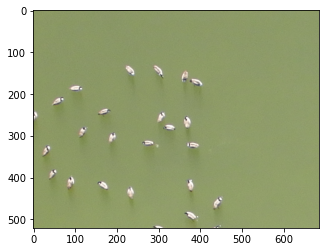

In [36]:
#DISPLAY A SINGLE TEST IMAGE

fig, ax = plt.subplots()

img = cv2.imread(imgpath+"/FWS_MaxwellLake13_20171215_1_00613_02_03.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)

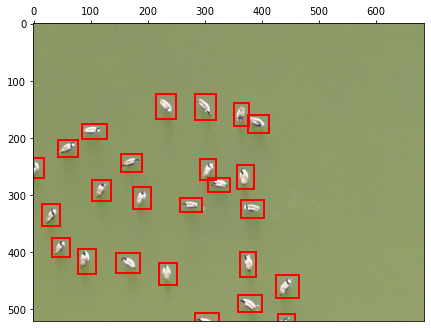

In [37]:
#DISPLAY ALL BOUNDING BOXES ON TEST IMAGE

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)

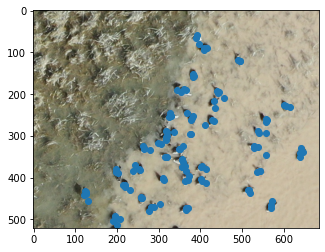

In [16]:
#DISPLAY CENTER COORDINATES ON TEST IMAGE

fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(x,y)

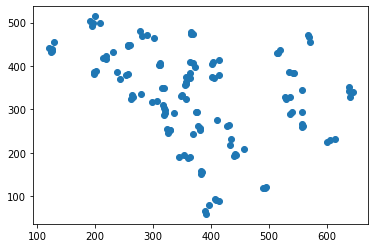

In [17]:
#EXAMINE SCATTERPLOT OF CENTERPOINTS

#These end up rotated 180 degrees and I'm too lazy to fix it
plt.scatter(array[:, 0], array[:, 1])
plt.show()

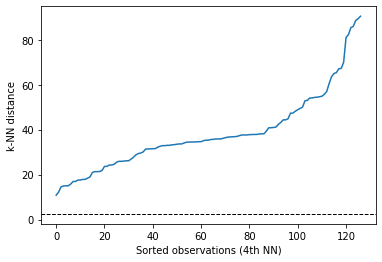

In [18]:
#DETERIMINE NEAREST NEIGHBOR DISTANCE FOR DBSCAN

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=10).fit(new)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(new)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

#Pick the number at the point of the curve where it begins to rise steeply after its plateau

In [19]:
#DEFINE VISUALIZATION PARAMETERS FOR DBSCAN OUTPUTS
def plot_dbscan(db, X):
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y')

In [22]:
#RUN DBSCAN

#define parameters for clustering; eps is the k-nn distance value from above 
db = DBSCAN(eps=15, min_samples=5).fit(array)
#stores the cluster labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 116


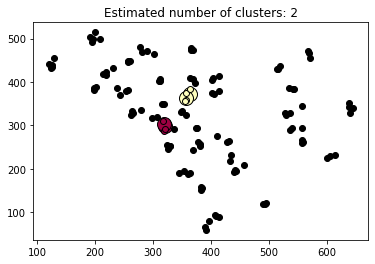

In [23]:
#VISUALIZE AND EXAMINE CLUSTERS
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = array[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = array[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()